In [1]:
import mlflow, numpy as np, tempfile, boto3, os, pickle, xarray as xr
import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update(
    # {
        # "pgf.texsystem": "pdflatex",
        # "font.family": "serif",
        # "text.usetex": True,
        # "pgf.rcfonts": False,
    # }
# )
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science', "no-latex"])
from jax import vmap
mlflow.set_tracking_uri("https://continuum.ergodic.io/experiments/")

In [2]:

un_exp = mlflow.get_experiment_by_name("uniform-64lines")
avg_exp = mlflow.get_experiment_by_name("optavg-64lines")
random_phase_exp = mlflow.get_experiment_by_name("randomphaser-64lines")


In [3]:
# filter runs with "temperature" in the mlflow run name
un_runs = mlflow.search_runs(experiment_names=[un_exp.name], filter_string="attribute.run_name LIKE '%temperature%'")
avg_runs = mlflow.search_runs(experiment_names=[avg_exp.name], filter_string="attribute.run_name LIKE '%temperature%'")
random_phase_runs = mlflow.search_runs(experiment_names=[random_phase_exp.name], filter_string="attribute.run_name LIKE '%temperature%'")

In [4]:
# get temperatures, intensities, gsls " eV", " W/cm^2", " um"

make_arr = lambda col_of_int, substring: np.array([float(val.strip(substring)) for val in col_of_int])
temperatures = make_arr(un_runs["params.units.reference electron temperature"].unique(), "eV")
intensities = make_arr(un_runs["params.units.laser intensity"].unique(), "W/cm^2")
gsls = make_arr(un_runs["params.density.gradient scale length"].unique(), "um")

temperatures.sort(), intensities.sort(), gsls.sort()

(None, None, None)

In [5]:
loss_values = xr.open_dataarray("../results/loss_values.nc")
un_loss_values = xr.DataArray(np.zeros((len(temperatures), len(intensities), len(gsls))), coords=(temperatures, intensities, gsls), dims=["temperature", "intensity", "gsl"])
avg_loss_values = xr.DataArray(np.zeros((len(temperatures), len(intensities), len(gsls))), coords=(temperatures, intensities, gsls), dims=["temperature", "intensity", "gsl"])
random_phase_loss_values = xr.DataArray(np.zeros((len(temperatures), len(intensities), len(gsls))), coords=(temperatures, intensities, gsls), dims=["temperature", "intensity", "gsl"])
amplitudes = np.zeros((len(temperatures), len(intensities), len(gsls), 64))
phases = np.zeros((len(temperatures), len(intensities), len(gsls), 64))

# s3 = boto3.client("s3")

with tempfile.TemporaryDirectory() as td:
    for i, temp in enumerate(temperatures):
        for j, intensity in enumerate(intensities):
            for k, gsl in enumerate(gsls):
                
                # if (temp == 2000) and (intensity == 4e14) and (gsl == 1400/3):
                #     print(run) 
                #     print(run["metrics.loss"])
                # loss_values[i, j, k] = run["metrics.loss"].values[0]    
                loc_dict = {"temperature": temp, "intensity": intensity, "gsl": gsl}
                

                un_run = un_runs[(un_runs["params.units.reference electron temperature"] == f"{temp} eV") &
                                (un_runs["params.units.laser intensity"] == f"{intensity} W/cm^2") &
                                (un_runs["params.density.gradient scale length"] == f"{gsl} um")]
                un_loss_values.loc[loc_dict] = un_run["metrics.loss"].values[0]

                avg_run = avg_runs[(avg_runs["params.units.reference electron temperature"] == f"{temp} eV") &
                                (avg_runs["params.units.laser intensity"] == f"{intensity} W/cm^2") &
                                (avg_runs["params.density.gradient scale length"] == f"{gsl} um")]      
                avg_loss_values.loc[loc_dict] = np.mean(avg_run["metrics.loss"].dropna().values)#[0]

                random_phase_run = random_phase_runs[(random_phase_runs["params.units.reference electron temperature"] == f"{temp} eV") &
                                (random_phase_runs["params.units.laser intensity"] == f"{intensity} W/cm^2") &
                                (random_phase_runs["params.density.gradient scale length"] == f"{gsl} um")]
                # print(loc_dict)
                random_phase_loss_values.loc[loc_dict] = random_phase_run["metrics.loss"].values[0]



In [6]:
loss_values.shape, un_loss_values.shape, avg_loss_values.shape, random_phase_loss_values.shape

((5, 4, 4), (5, 4, 4), (5, 4, 4), (5, 4, 4))

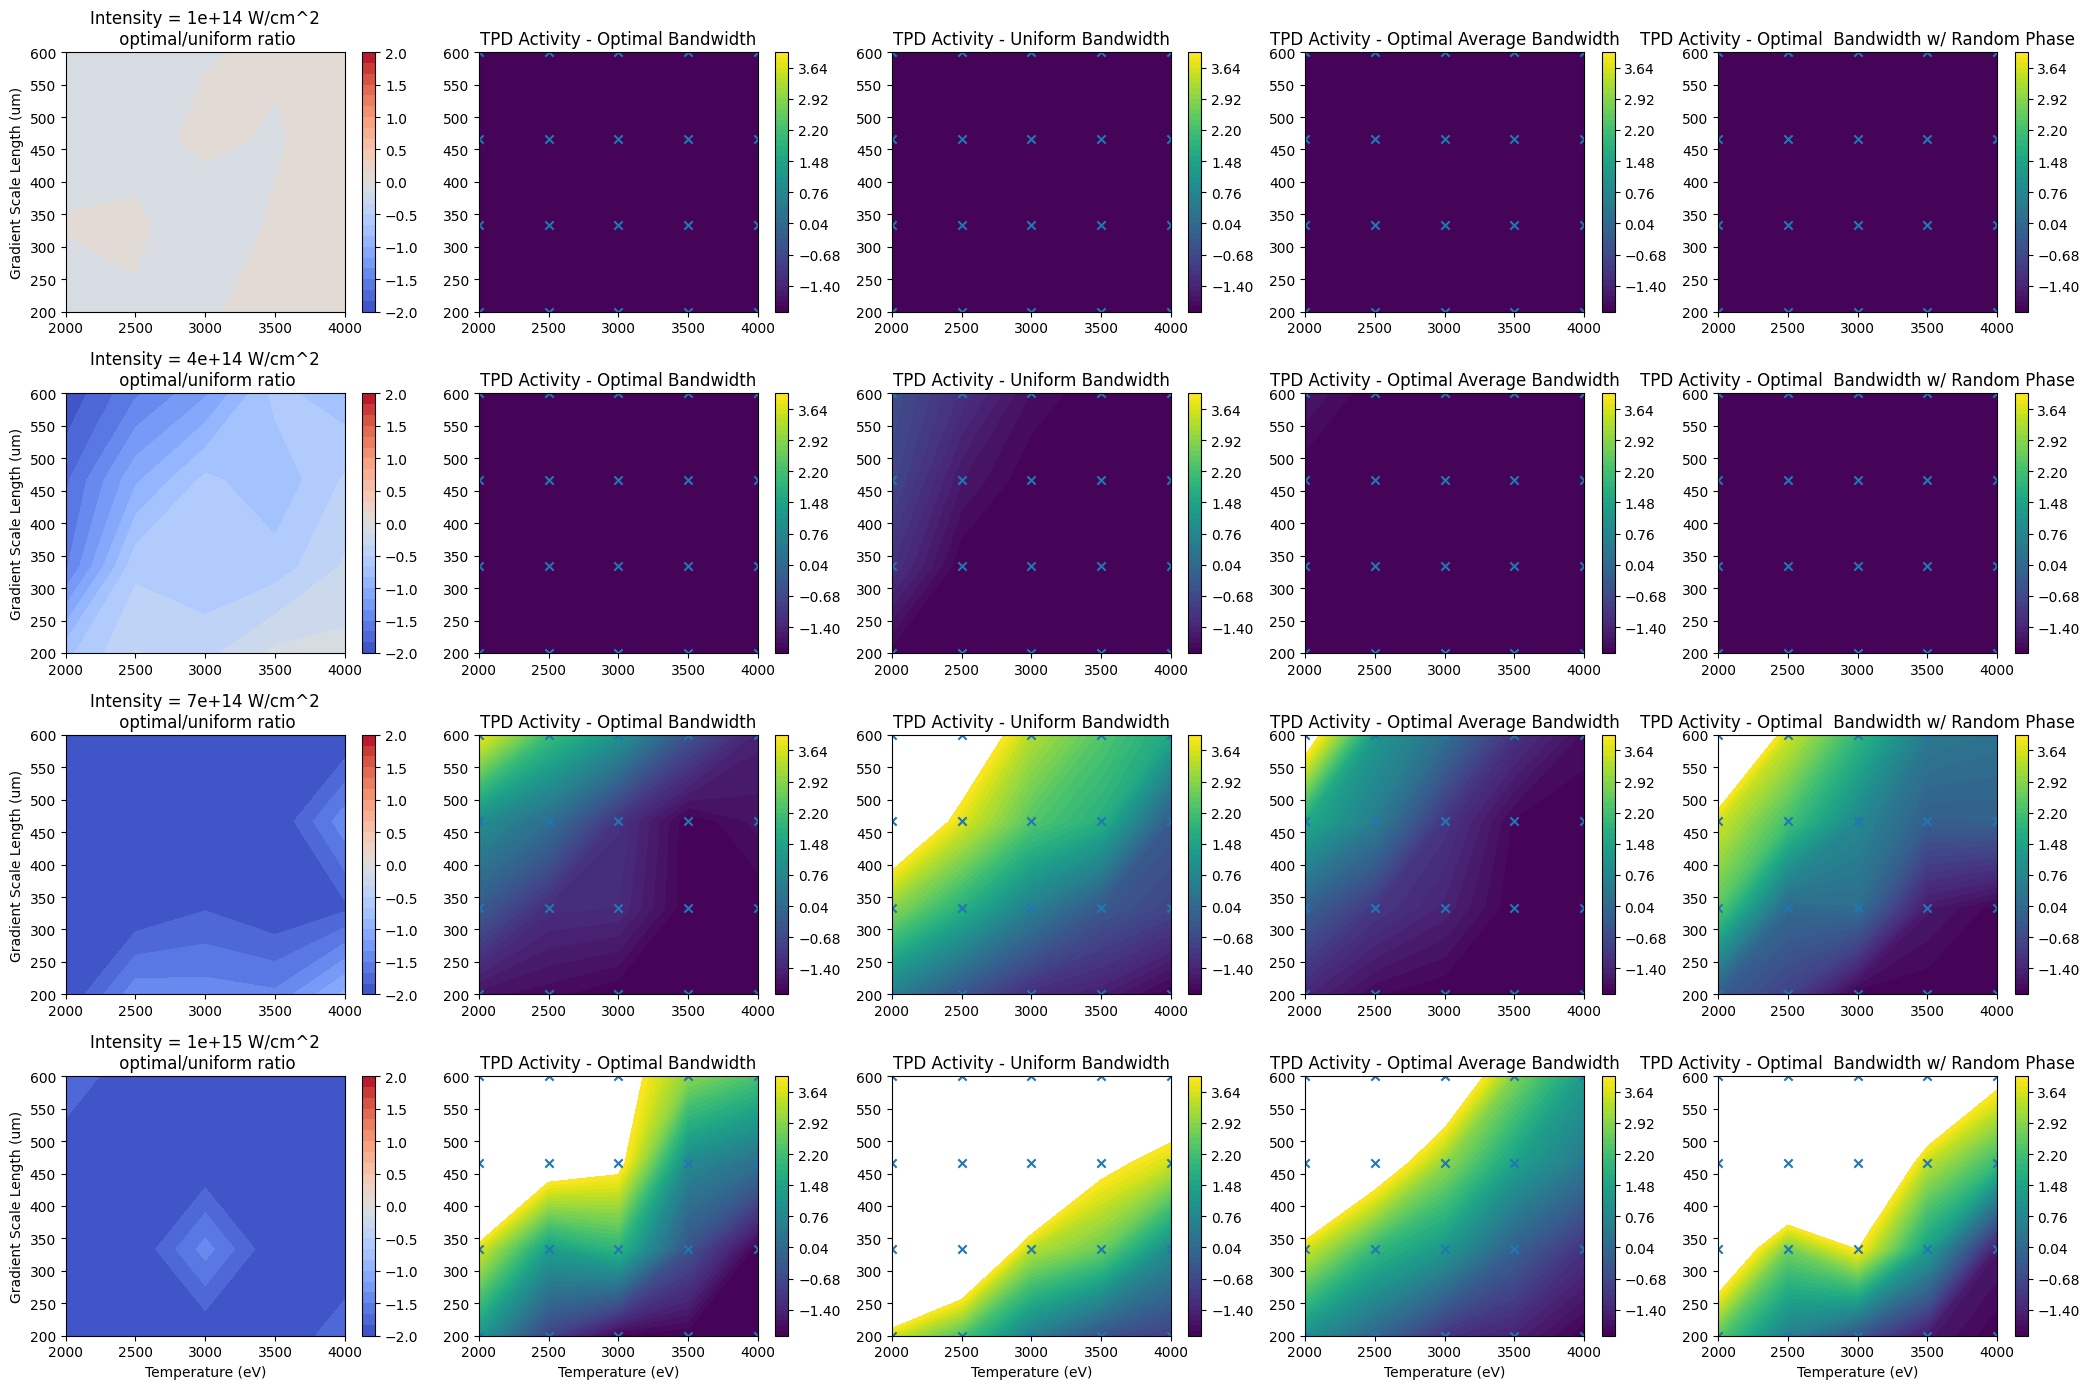

In [14]:
ratios =  loss_values-un_loss_values

fig, ax = plt.subplots(4, 5, figsize=(21, 14), tight_layout=True)
for _intind, intt in enumerate(intensities):
    plot_arr = xr.where(ratios.loc[{"intensity": intt}] < -2, ratios.loc[{"intensity": intt}]*0-2, ratios.loc[{"intensity": intt}])
    # print(plot_arr)
    # plot_arr.plot(ax=ax[_intind, 0], cmap="coolwarm") #, levels=25)
    c = ax[_intind, 0].contourf(temperatures, gsls, plot_arr.data.T, np.linspace(-2, 2, 25), cmap="coolwarm")
    fig.colorbar(c)
    ax[_intind, 0].set_title("Intensity = %.0e W/cm^2" % intensities[_intind] + "\n optimal/uniform ratio")
    
    threshold_val = -2

    clevs=np.linspace(-2, 4, 51) 

    plot_arr = xr.where(loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val, loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 1].contourf(temperatures, gsls, plot_arr.T, 25, cmap="viridis", levels=clevs)
    tgrid, gslgrid = np.meshgrid(temperatures, gsls)
    ax[_intind, 1].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 1].set_title("TPD Activity - Optimal Bandwidth")

    # if _intind == 1:
    #     print(intensities[_intind], plot_arr.T)
        # print(loss_values[:, :, _intind])

    plot_arr = xr.where(un_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val, un_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 2].contourf(temperatures, gsls, plot_arr.T, 25, cmap="viridis", levels=clevs)
    ax[_intind, 2].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 2].set_title("TPD Activity - Uniform Bandwidth")

    plot_arr = xr.where(avg_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val, avg_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 3].contourf(temperatures, gsls, plot_arr.T, 25, cmap="viridis", levels=clevs)
    ax[_intind, 3].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 3].set_title("TPD Activity - Optimal Average Bandwidth")

    plot_arr = xr.where(random_phase_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val, random_phase_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 4].contourf(temperatures, gsls, plot_arr.T, 25, cmap="viridis", levels=clevs)
    ax[_intind, 4].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 4].set_title("TPD Activity - Optimal  Bandwidth w/ Random Phase")

ax[0, 0].set_ylabel("Gradient Scale Length (um)")
ax[1, 0].set_ylabel("Gradient Scale Length (um)")
ax[2, 0].set_ylabel("Gradient Scale Length (um)")
ax[3, 0].set_ylabel("Gradient Scale Length (um)")
ax[-1, 0].set_xlabel("Temperature (eV)")
ax[-1, 1].set_xlabel("Temperature (eV)")
ax[-1, 2].set_xlabel("Temperature (eV)")
ax[-1, 3].set_xlabel("Temperature (eV)")
ax[-1, 4].set_xlabel("Temperature (eV)")

fig.savefig("./bw_comparison.png", bbox_inches="tight")

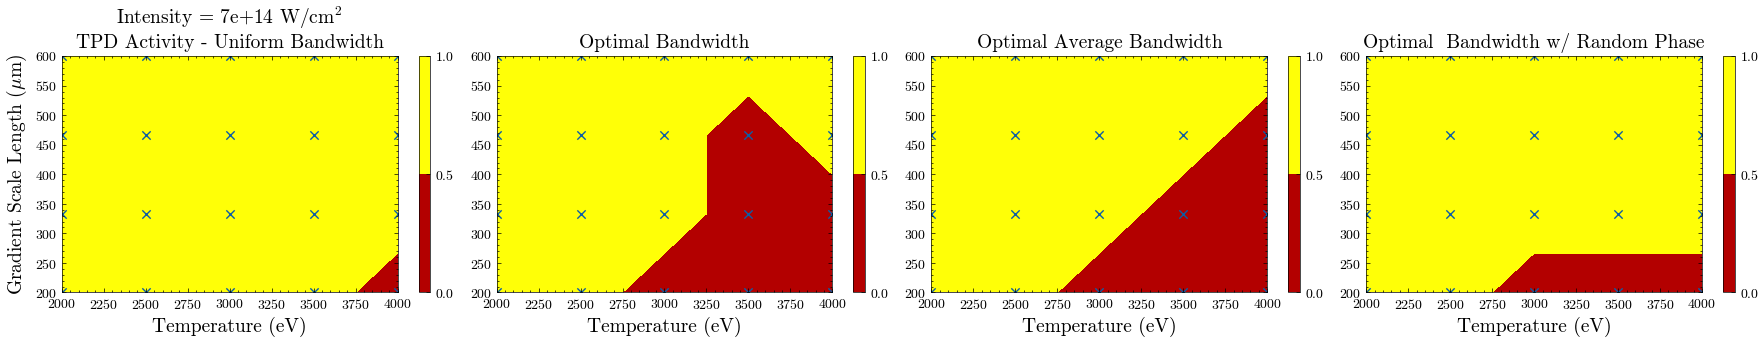

In [10]:
# ratios =  loss_values-un_loss_values

tw = 36.22
aspect_ratio = 1/5
scale = 0.5
width = tw * scale
height = width * aspect_ratio

fig, ax = plt.subplots(1, 4, figsize=(width, height), tight_layout=True)
_intind = 2
intt = intensities[_intind]
# for _intind, intt in enumerate(intensities[1:]):
    # plot_arr = xr.where(ratios.loc[{"intensity": intt}] < -2, ratios.loc[{"intensity": intt}]*0-2, ratios.loc[{"intensity": intt}])
    # # print(plot_arr)
    # # plot_arr.plot(ax=ax[_intind, 0], cmap="coolwarm") #, levels=25)
    # c = ax[_intind, 0].contourf(temperatures, gsls, plot_arr.data.T, np.linspace(-2, 2, 25), cmap="coolwarm")
    # fig.colorbar(c)
    # ax[_intind, 0].set_title("Intensity = %.0e W/cm^2" % intensities[_intind] + "\n optimal/uniform ratio")
    
threshold_val = -2

clevs=np.linspace(0, 1, 3)
tgrid, gslgrid = np.meshgrid(temperatures, gsls)



# if _intind == 1:
#     print(intensities[_intind], plot_arr.T)
    # print(loss_values[:, :, _intind])

plot_arr = xr.where(un_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*un_loss_values.loc[{"intensity": intt}])
c = ax[0].contourf(temperatures, gsls, plot_arr.T, 25, cmap="hot", levels=clevs)
ax[0].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
fig.colorbar(c)
ax[0].set_title("Intensity = %.0e W/cm$^2$" % intensities[_intind] + "\nTPD Activity - Uniform Bandwidth", fontsize=14)

plot_arr = xr.where(loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*loss_values.loc[{"intensity": intt}])
c = ax[1].contourf(temperatures, gsls, plot_arr.T, 25, cmap="hot", levels=clevs)
ax[1].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
fig.colorbar(c)
ax[1].set_title("Optimal Bandwidth", fontsize=14)

plot_arr = xr.where(avg_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*avg_loss_values.loc[{"intensity": intt}])
c = ax[2].contourf(temperatures, gsls, plot_arr.T, 25, cmap="hot", levels=clevs)
ax[2].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
fig.colorbar(c)
ax[2].set_title("Optimal Average Bandwidth", fontsize=14)

plot_arr = xr.where(random_phase_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*random_phase_loss_values.loc[{"intensity": intt}])
c = ax[3].contourf(temperatures, gsls, plot_arr.T, 25, cmap="hot", levels=clevs)
ax[3].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
fig.colorbar(c)
ax[3].set_title("Optimal  Bandwidth w/ Random Phase", fontsize=14)

ax[0].set_ylabel("Gradient Scale Length ($\mu$m)", fontsize=14)
# ax[1, 0].set_ylabel("Gradient Scale Length ($\mu$m)", fontsize=14)
# ax[2, 0].set_ylabel("Gradient Scale Length ($\mu$m)", fontsize=14)

ax[0].set_xlabel("Temperature (eV)", fontsize=14)
ax[1].set_xlabel("Temperature (eV)", fontsize=14)
ax[2].set_xlabel("Temperature (eV)", fontsize=14)
ax[3].set_xlabel("Temperature (eV)", fontsize=14)

fig.savefig("./bw_comparison.pdf", bbox_inches="tight")

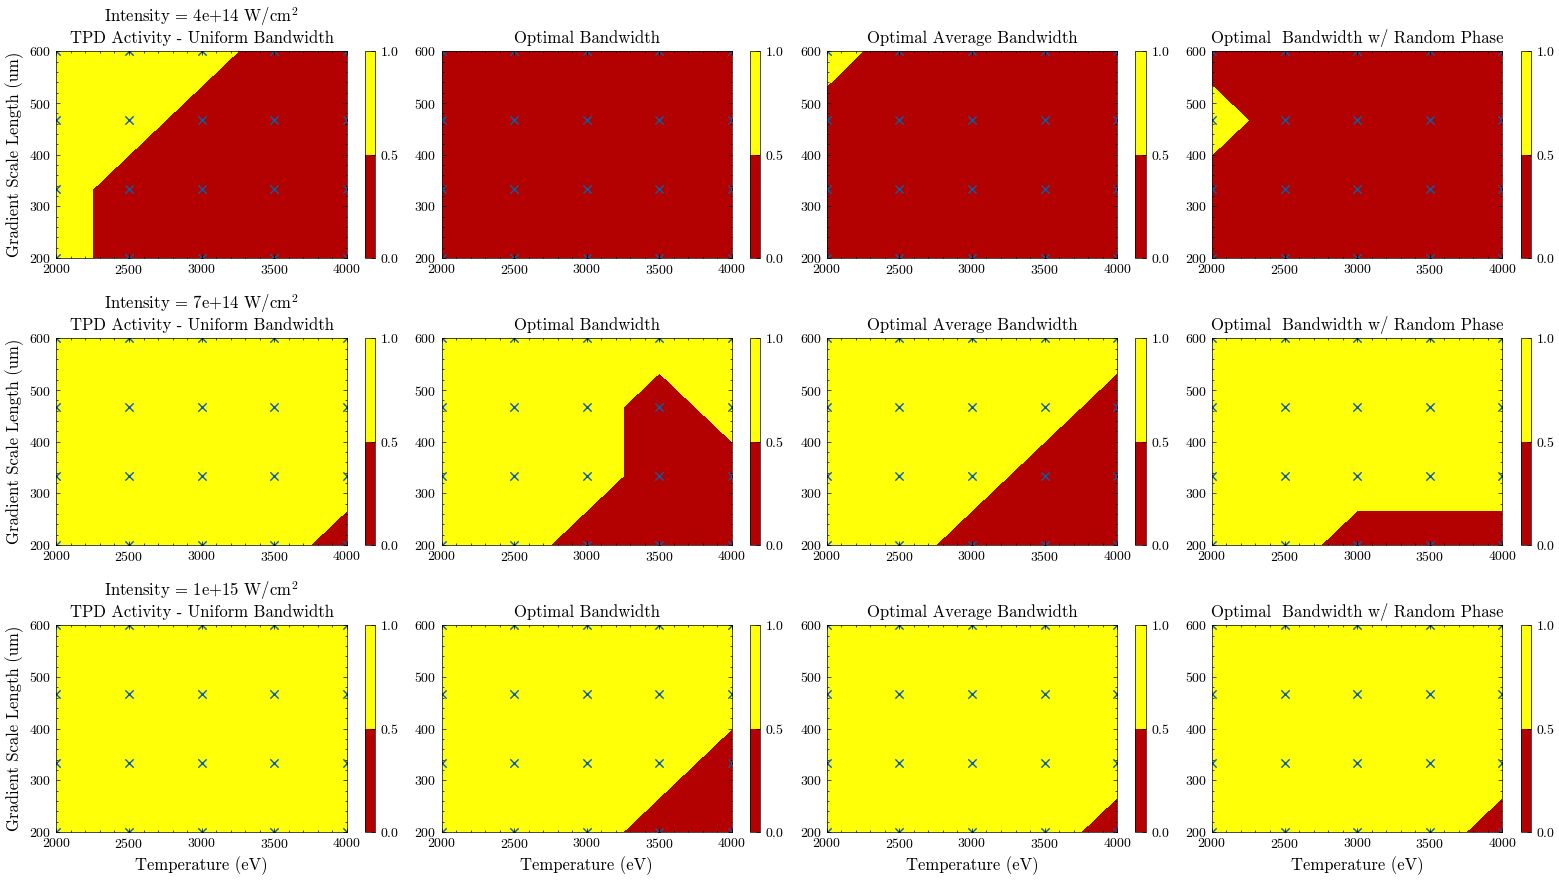

In [ ]:
ratios =  loss_values-un_loss_values

fig, ax = plt.subplots(3, 4, figsize=(16, 9), tight_layout=True)
for _intind, intt in enumerate(intensities[1:]):
    # plot_arr = xr.where(ratios.loc[{"intensity": intt}] < -2, ratios.loc[{"intensity": intt}]*0-2, ratios.loc[{"intensity": intt}])
    # # print(plot_arr)
    # # plot_arr.plot(ax=ax[_intind, 0], cmap="coolwarm") #, levels=25)
    # c = ax[_intind, 0].contourf(temperatures, gsls, plot_arr.data.T, np.linspace(-2, 2, 25), cmap="coolwarm")
    # fig.colorbar(c)
    # ax[_intind, 0].set_title("Intensity = %.0e W/cm^2" % intensities[_intind] + "\n optimal/uniform ratio")
    
    threshold_val = -2

    clevs=np.linspace(0, 1, 3)
    tgrid, gslgrid = np.meshgrid(temperatures, gsls)

    

    # if _intind == 1:
    #     print(intensities[_intind], plot_arr.T)
        # print(loss_values[:, :, _intind])

    plot_arr = xr.where(un_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*un_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 0].contourf(temperatures, gsls, plot_arr.T, 25, cmap="hot", levels=clevs)
    ax[_intind, 0].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 0].set_title("Intensity = %.0e W/cm$^2$" % intensities[_intind+1] + "\nTPD Activity - Uniform Bandwidth")

    plot_arr = xr.where(loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 1].contourf(temperatures, gsls, plot_arr.T, 25, cmap="hot", levels=clevs)
    ax[_intind, 1].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 1].set_title("Optimal Bandwidth")

    plot_arr = xr.where(avg_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*avg_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 2].contourf(temperatures, gsls, plot_arr.T, 25, cmap="hot", levels=clevs)
    ax[_intind, 2].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 2].set_title("Optimal Average Bandwidth")

    plot_arr = xr.where(random_phase_loss_values.loc[{"intensity": intt}] < threshold_val, threshold_val*0, 1+0*random_phase_loss_values.loc[{"intensity": intt}])
    c = ax[_intind, 3].contourf(temperatures, gsls, plot_arr.T, 25, cmap="hot", levels=clevs)
    ax[_intind, 3].scatter(tgrid.flatten(), gslgrid.flatten(), marker="x")
    fig.colorbar(c)
    ax[_intind, 3].set_title("Optimal  Bandwidth w/ Random Phase")

ax[0, 0].set_ylabel("Gradient Scale Length ($\mu$m)", fontsize=12)
ax[1, 0].set_ylabel("Gradient Scale Length ($\mu$m)", fontsize=12)
ax[2, 0].set_ylabel("Gradient Scale Length ($\mu$m)", fontsize=12)

ax[-1, 0].set_xlabel("Temperature (eV)", fontsize=12)
ax[-1, 1].set_xlabel("Temperature (eV)", fontsize=12)
ax[-1, 2].set_xlabel("Temperature (eV)", fontsize=12)
ax[-1, 3].set_xlabel("Temperature (eV)", fontsize=12)

fig.savefig("./bw_comparison.png", bbox_inches="tight")

## Download Drivers

In [9]:
optimal_bw = xr.open_dataset("../results/optimal_bw.nc")
optimal_bw

<xarray.Dataset> Size: 83kB
Dimensions:      (delta_omega: 64, temperature: 5, intensity: 4, gsl: 4)
Coordinates:
  * delta_omega  (delta_omega) float64 512B -0.015 -0.01452 ... 0.01452 0.015
  * temperature  (temperature) float64 40B 2e+03 2.5e+03 3e+03 3.5e+03 4e+03
  * intensity    (intensity) float64 32B 1e+14 4e+14 7e+14 1e+15
  * gsl          (gsl) float64 32B 200.0 333.3 466.7 600.0
Data variables:
    amplitudes   (temperature, intensity, gsl, delta_omega) float64 41kB ...
    phases       (temperature, intensity, gsl, delta_omega) float64 41kB ...

In [ ]:
loc_dict = {"temperature": 4000, "intensity": 7e14, "gsl": 200}

fig, ax = plt.subplots(1, 3, figsize=(12, 3), tight_layout=True)
ax[0].scatter(optimal_bw.coords["delta_omega"], optimal_bw["amplitudes"].loc[loc_dict].data)
ax[0].set_title("Optimal Amplitude", fontsize=12)
ax[0].set_xlabel("Frequency Shift", fontsize=12)
ax[0].grid()

ax[1].semilogy(optimal_bw.coords["delta_omega"], optimal_bw["amplitudes"].loc[loc_dict].data, "o")
ax[1].set_title("Optimal Amplitude", fontsize=12)
ax[1].set_xlabel("Frequency Shift", fontsize=12)
ax[1].grid()

ax[2].scatter(optimal_bw.coords["delta_omega"], optimal_bw["phases"].loc[loc_dict].data)
ax[2].set_title("Optimal Phase", fontsize=12)
ax[2].set_xlabel("Frequency Shift", fontsize=12)
ax[2].grid()

# loc dict in suptitle
fig.suptitle("Temperature = %.0f eV, Intensity = %.0e W/cm$^2$, $L_n$ = %.0f um" % (loc_dict["temperature"], loc_dict["intensity"], loc_dict["gsl"]), fontsize=12)


NameError: name 'plt' is not defined

Text(0.5, 0, '$\\Delta \\omega$ (%)')

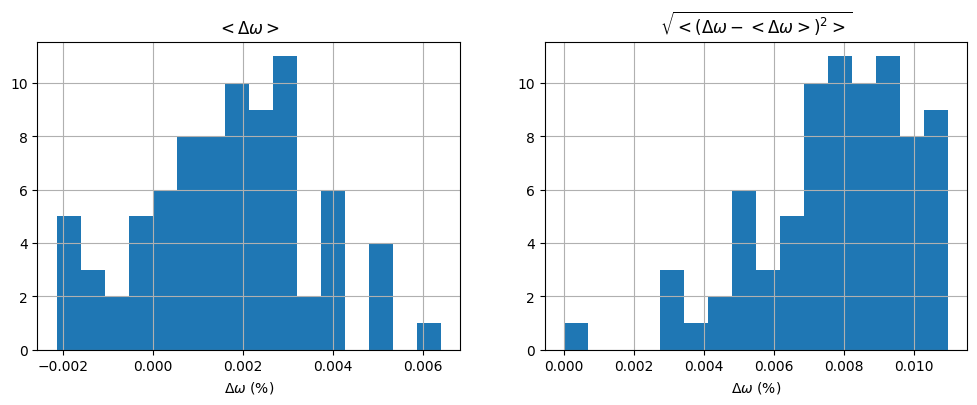

In [19]:
fig, ax = plt.subplots(1, 2,figsize=(12, 4))
ax[0].hist(mean_delta_omega.flatten(),16)
ax[0].grid()
ax[0].set_title(r"$<\Delta \omega>$")
ax[0].set_xlabel(r"$\Delta \omega$ (%)")

ax[1].hist(mean_delta_omega_22.flatten(),16)
ax[1].grid()
ax[1].set_title(r"$\sqrt{<(\Delta \omega - <\Delta \omega>)^2>}$")
ax[1].set_xlabel(r"$\Delta \omega$ (%)")

In [8]:
from adept import ergoExo
from ml4tpd.module import TPDModule
import yaml

In [ ]:
from jax import jit
@jit
def get_one_xprofile(_t, _y, _light_wave):
    return exo.adept_module.diffeqsolve_quants["terms"].vector_field.light.laser_update(_t, _y, _light_wave)[:, 0, 1]

Ignoring xmax and xmin and using the density gradient scale length to set the grid size
Grid size = L / 0.25 * (nmax - nmin) =  239.99999999999994 um


/global/u2/a/archis/adept/adept/_lpse2d/helpers.py:271: RuntimeWarning: divide by zero encountered in divide
  one_over_ksq = np.array(1.0 / (cfg_grid["kx"][:, None] ** 2.0 + cfg_grid["ky"][None, :] ** 2.0))


In [211]:
nc = 64
un_nc = 8
this_temp = 2000
this_int = 4e14
this_gsl = 600

nt = 512
num_phases = 16


loc_dict = {"temperature": this_temp, "intensity": this_int, "gsl": this_gsl}
amplitudes = amplitudes_xr.loc[loc_dict].values
phases = phases_xr.loc[loc_dict].values
un_dw = np.linspace(-0.015, 0.015, un_nc)

light_wave = {"delta_omega": delta_omega, "phases": phases, "intensities": amplitudes} 
un_light_wave = [{"delta_omega": un_dw, "phases": np.random.uniform(-np.pi, np.pi, un_nc), "intensities": np.ones(un_nc)/un_nc} for _ in range(num_phases)]

In [ ]:
from tqdm import tqdm

# get config 
parent_runs = runs[runs["params.density.gradient scale length"] == f"{this_gsl:.1f} um"]
artifact_path = parent_runs["artifact_uri"].values[0]
artifact_path += "/config.yaml"
s3.download_file("public-ergodic-continuum", artifact_path[30:], "./config.yaml")
with open("./config.yaml", "r") as fi:
    config = yaml.safe_load(fi)

exo = ergoExo()
modules = exo._setup_(config, None, TPDModule, log=False)

nx = config["grid"]["nx"]
tmin, tmax = 4, 5

tax = np.linspace(tmin, tmax, nt)
y = exo.adept_module.state
e0_vs_t = np.zeros((nt, nx), dtype=np.complex64)
une0_vs_t = np.zeros((nt, nx, num_phases), dtype=np.complex64)

from jax import jit
@jit
def get_one_xprofile(_t, _y, _light_wave):
    return exo.adept_module.diffeqsolve_quants["terms"].vector_field.light.laser_update(_t, _y, _light_wave)[:, 0, 1]


for i, t in enumerate(tax):
    e0_vs_t[i] = get_one_xprofile(t, y, light_wave)
    for j in range(num_phases):
        une0_vs_t[i, :, j] = get_one_xprofile(t, y, un_light_wave[j])
    

dt = tax[1]-tax[0]
w0_xt = np.gradient(np.unwrap(np.angle(e0_vs_t), axis=0), axis=0)/dt
un_w0_xt = np.gradient(np.unwrap(np.angle(np.mean(une0_vs_t, axis=-1)), axis=0), axis=0)/dt

Ignoring xmax and xmin and using the density gradient scale length to set the grid size
Grid size = L / 0.25 * (nmax - nmin) =  239.99999999999994 um


/global/u2/a/archis/adept/adept/_lpse2d/helpers.py:271: RuntimeWarning: divide by zero encountered in divide
  one_over_ksq = np.array(1.0 / (cfg_grid["kx"][:, None] ** 2.0 + cfg_grid["ky"][None, :] ** 2.0))


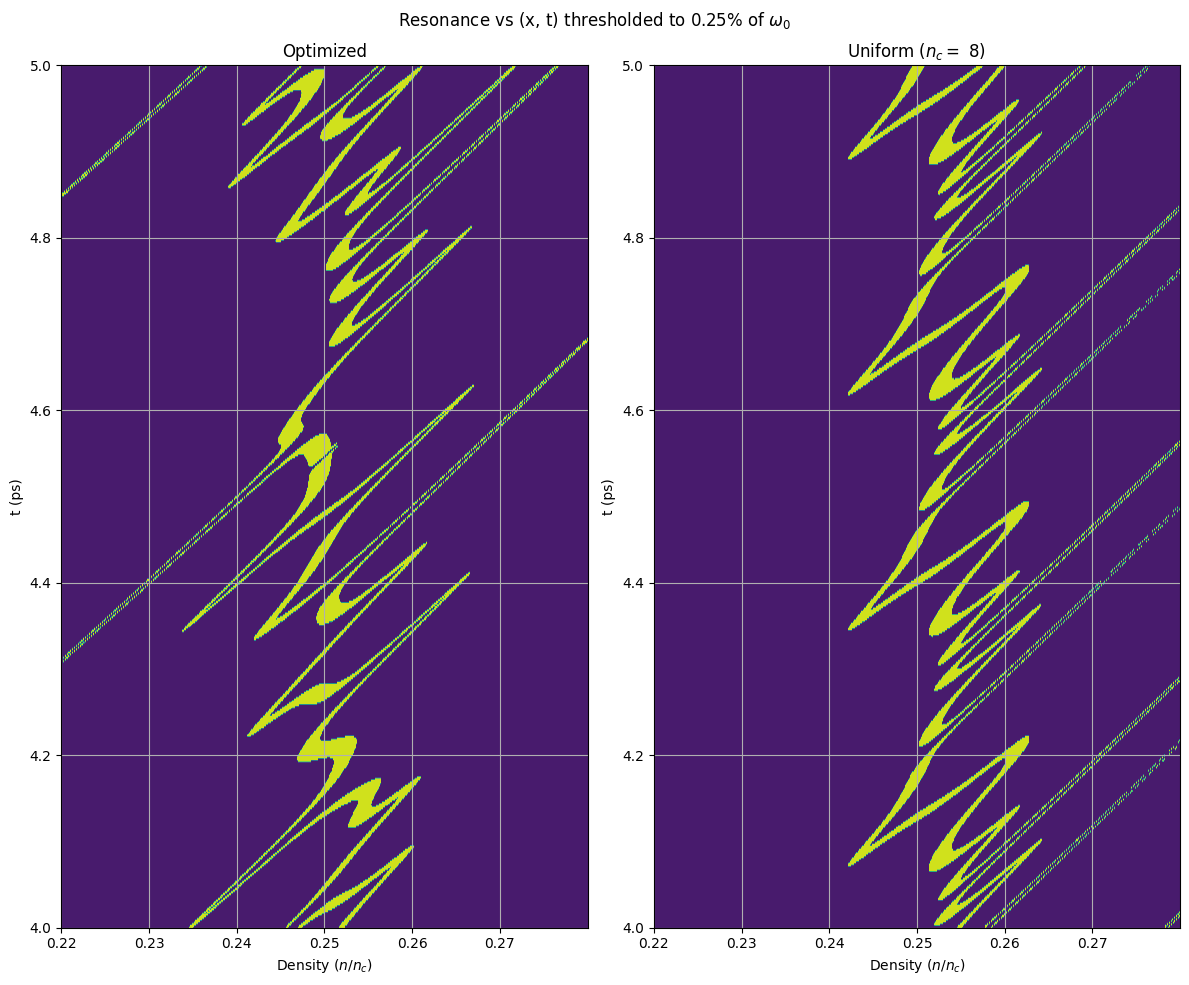

In [213]:
density = y["background_density"][:, 0]
nmin, nmax = 0.22, 0.28

clevs = np.linspace(-2, 2, 10)

density_slice = slice(np.argmin(np.abs(density-nmin)), np.argmin(np.abs(density-nmax)))
w0 = 5366.528681791605
wp0 = 2683.2643408958024
wp = np.sqrt(density/0.25)*wp0
opt_match = w0 - w0_xt - 2*wp
opt_match = opt_match[:, density_slice]
opt_match /= w0/100
threshold_percent = 0.25
opt_match = np.where(np.abs(opt_match) < threshold_percent, 1, 0)

uniform_match = w0 - un_w0_xt - 2*wp
uniform_match = uniform_match[:, density_slice]
uniform_match /= w0/100
uniform_match = np.where(np.abs(uniform_match) < threshold_percent, 1, 0)

fig, ax = plt.subplots(1, 2, figsize=(12, 10), tight_layout=True)
c = ax[0].contourf(density[density_slice], tax, opt_match) #, levels=clevs, cmap="coolwarm")
ax[0].set_title("Optimized")
ax[0].set_xlabel("Density $(n/n_c)$")
ax[0].set_ylabel("t (ps)")
fig.suptitle("Resonance vs (x, t) thresholded to $0.25\%$ of $\omega_0$")
# ax[0].set_ylim(tmin, tmax)
ax[0].grid()
# fig.colorbar(c)
c = ax[1].contourf(density[density_slice], tax, uniform_match) #, levels=clevs, cmap="coolwarm")
ax[1].set_xlabel("Density $(n/n_c)$")
ax[1].set_ylabel("t (ps)")
# ax[1].set_ylim(tmin, tmax)
ax[1].set_title(f"Uniform ($n_c = $ {un_nc})")
ax[1].grid()
# fig.colorbar(c)

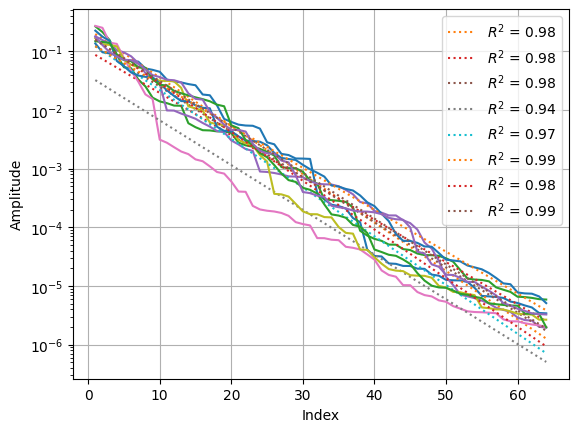

In [229]:
amp_inds = np.arange(64)+1
for _ in range(8):
    temp = np.random.choice(temperatures)
    intensity = np.random.choice(intensities)
    gsl = np.random.choice(gsls)
    loc_dict = {"temperature": temp, "intensity": intensity, "gsl": gsl}
    sorted_amps = np.sort(optimal_bw["amplitudes"].loc[loc_dict])[::-1]
    # slope, intercept, r_value, _, _ = linregress(np.log(amp_inds), np.log(sorted_amps))
    slope, intercept, r_value, _, _ = linregress(amp_inds, np.log(sorted_amps))
    plt.semilogy(amp_inds, sorted_amps)
    # plt.semilogy(amp_inds, np.exp(intercept)*amp_inds**slope, ":" ,label=f"$R^2$ = {r_value**2:.2f}")    
    plt.semilogy(amp_inds, np.exp(intercept)*np.exp(slope*amp_inds), ":", label=f"$R^2$ = {r_value**2:.2f}")

plt.xlabel("Index")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
from scipy.stats import linregress



np.float64(-3.208801866797209)